In [15]:
import os
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision
import torch
import cv2
import pandas as pd
import time

from BEN_processingData import imageDataset
from BEN_processingData import processingDataset

import BEN_modelCNN as model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rootDir = './../data/raw/'

# hyper parameters
inChannel = 1
numClasses = 7
learningRate = 0.001
batchSize = 100
numEpochs = 6


import itertools
import numpy as np
import matplotlib.pyplot as plt


In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
 
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
dataTransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(26),
    transforms.ToTensor()
    ])


data = processingDataset( rootDir )
df = data.makeData ( draw = False  )

#Load data

dataset =imageDataset( df = df , rootDir = rootDir , transform = dataTransform )
lenDataset = len (dataset)
#split dataset to train and valid
lenTrain = int (lenDataset*0.75)
lenValid = lenDataset - lenTrain
trainset , validset = torch.utils.data.random_split(dataset, [lenTrain,lenValid])
trainLoader = DataLoader(dataset=trainset , batch_size=batchSize, shuffle=True) # shuffle is mean is mix 
testLoader = DataLoader(dataset=validset)

model = model.CNN( numClasses ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

# Train the model
totalStep = len(trainLoader)
Ptime = time.time()
beginTime = time.time()


In [19]:

for epoch in range(numEpochs):
    for i, (images, labels) in enumerate(trainLoader):
        images = images.to(device)
        labels = labels.to(device)
        #print ( labels.shape)

        # Forward pass
        #print ( f"shape image {images.shape} and label shape {labels.shape} ")
        #print ( labels )
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sec = (time.time() - Ptime)
        if (i+1) % 100 == 0:

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, time: {:.2f} s'
                   .format(epoch+1, numEpochs, i+1, totalStep, loss.item(), sec))
            Ptime = time.time()


Epoch [1/6], Step [100/173], Loss: 0.0422, time: 26.54 s
Epoch [2/6], Step [100/173], Loss: 0.0069, time: 11.39 s
Epoch [3/6], Step [100/173], Loss: 0.0020, time: 11.41 s
Epoch [4/6], Step [100/173], Loss: 0.0036, time: 11.44 s
Epoch [5/6], Step [100/173], Loss: 0.0007, time: 12.44 s
Epoch [6/6], Step [100/173], Loss: 0.0044, time: 12.33 s


In [20]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testLoader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), './../modelPytorch/model1.pt')
hour = ( time.time()  - beginTime ) / (60*60)

print ("training Done , total time during training is: {:.3f} h ".format(hour) )


from sklearn.metrics import confusion_matrix

nb_classes = 7

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

# that is print confusion matrix 



Test Accuracy of the model on the 10000 test images: 99.84323288625674 %
training Done , total time during training is: 0.027 h 


In [22]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testLoader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

plt.figure(figsize=(7,7))

#plot_confusion_matrix(conf_mat , testLoader.)


[[1009    1    0    0    0    3    0]
 [   0  594    1    1    0    0    0]
 [   0    0  294    0    0    0    0]
 [   0    0    0  849    0    0    0]
 [   1    1    0    0  643    0    0]
 [   0    0    0    0    1 1217    0]
 [   0    0    0    0    0    0 1126]]
[ 99.60513327  99.66442953 100.         100.          99.68992248
  99.91789819 100.        ]


<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

Confusion matrix, without normalization
[[1009    1    0    0    0    3    0]
 [   0  594    1    1    0    0    0]
 [   0    0  294    0    0    0    0]
 [   0    0    0  849    0    0    0]
 [   1    1    0    0  643    0    0]
 [   0    0    0    0    1 1217    0]
 [   0    0    0    0    0    0 1126]]


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

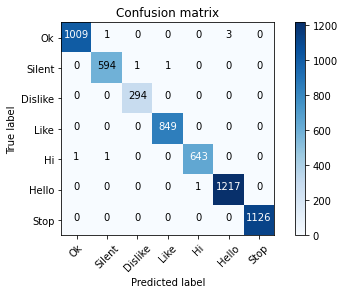

In [26]:
plot_confusion_matrix(conf_mat , ['Ok', 'Silent', 'Dislike', 'Like', 'Hi', 'Hello', 'Stop'])
plt.imshow